In [1]:
import ptb_data
import audio_utilities
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = ptb_data.get_ptb_data(num_samples=2, sample_length=4096)

In [3]:
fft_length = 64
fft_hop = 16

In [4]:
spectrogram = audio_utilities.stft_for_reconstruction(data[0], fft_length, fft_hop)

In [5]:
spectrogram_mag = np.absolute(spectrogram)**0.5

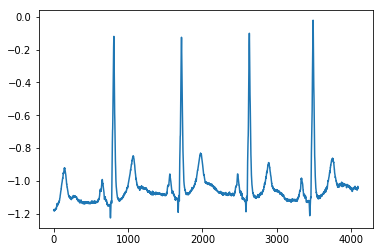

In [6]:
plt.plot(data[0])

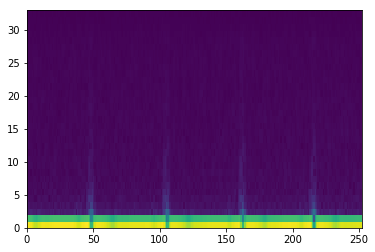

In [7]:
plt.pcolormesh(spectrogram_mag.T[:,:])

In [8]:
chopped_spectrogram = spectrogram

In [9]:
#chopped_spectrogram[:,:] = 0

In [10]:
chopped_mag = np.absolute(chopped_spectrogram)**0.5

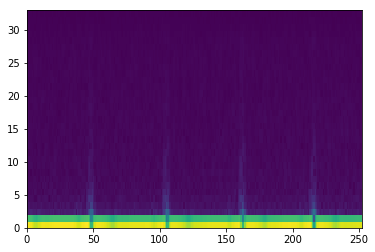

In [11]:
plt.pcolormesh(chopped_mag.T[:,:])

In [12]:
reconstruct = audio_utilities.istft_for_reconstruction(chopped_spectrogram, fft_length, fft_hop)

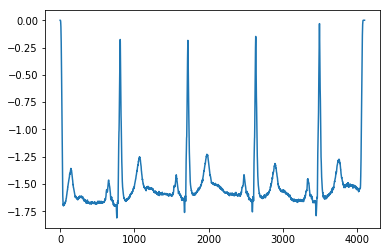

In [13]:
plt.plot(reconstruct)

In [15]:
print(spectrogram.T.shape)

(33, 252)


In [19]:
spect_real_valued = np.zeros((2,33,252))

In [21]:
spect_real_valued[1,2,4]

0.0